In [39]:
%pip install tf-keras

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import shap

### Data Preparation

In [2]:
# Load dataset
df = pd.read_csv('C:/Users/Startklar/OneDrive - student.HTW-Berlin.de/Desktop/WiSe 2425/M11 Seminar/Dataset/german.csv', delimiter=';')
X = df.drop('Creditability', axis=1)
y = df['Creditability']

### Just for features name later
feature_names = X.columns.tolist()

# Set seed for reproducibility
torch.manual_seed(42)

# Convert DataFrame to numpy
X = X.to_numpy()
y = y.to_numpy()

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
df.columns

Index(['Creditability', 'Account_Balance', 'Duration_of_Credit_monthly',
       'Payment_Status_of_Previous_Credit', 'Purpose', 'Credit_Amount',
       'Value_Savings_Stocks', 'Length_of_current_employment',
       'Instalment_per_cent', 'Sex_Marital_Status', 'Guarantors',
       'Duration_in_Current_address', 'Most_valuable_available_asset',
       'Age_years', 'Concurrent_Credits', 'Type_of_apartment',
       'No_of_Credits_at_this_Bank', 'Occupation', 'No_of_dependents',
       'Telephone', 'Foreign_Worker'],
      dtype='object')

In [5]:
df.shape

(1000, 21)

### Data preprocessing

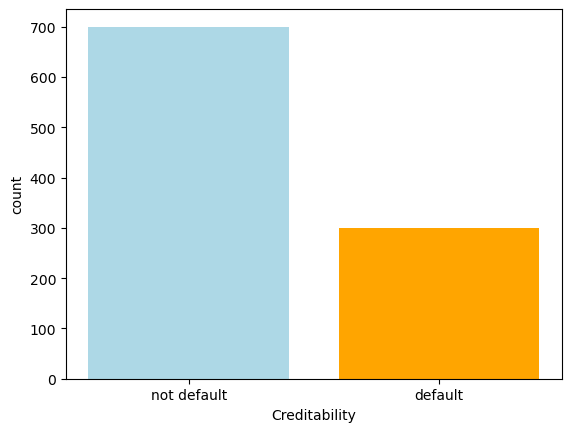

In [3]:
Count_credit = df['Creditability'].value_counts()  ### Values 0 and 1
fig, ax = plt.subplots()

x = Count_credit.rename(index = {1: 'not default', 0: 'default'}).index
y = Count_credit

ax.bar(x, y, color = ('LightBlue', 'orange'))


ax.set_xlabel('Creditability')
ax.set_ylabel('count')
ax.legend
plt.show()

In [42]:
# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

# Calculate class weights
class_counts = np.bincount(y_train_tensor.numpy().astype(int).flatten())
pos_weight = class_counts[0] / class_counts[1]

### Artificial Neural Networks Model 

In [43]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_features, neurons, hidden_layers, output):
        super().__init__()
        self.input_layer = nn.Linear(input_features, neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(neurons, neurons) for i in range(hidden_layers)])
        self.output_layer = nn.Linear(neurons, output)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.input_layer(x))
        for layer in self.hidden_layers:
            x = self.relu(layer(x))
        x = self.output_layer(x)
        return x

#### Hyperparameters Adjustment

In [44]:
# Adjust hyperparameters
input_features = X_train_tensor.shape[1]
neurons = 40
hidden_layers = 3
output = 1
NN_model = NeuralNetwork(input_features, neurons, hidden_layers, output)

learning_rate = 0.0001
# Set loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight]))
optimizer = optim.Adam(NN_model.parameters(), lr=learning_rate)

# Training loop
n_epochs = 100
batch_size = 128

#### ANN Metrics Measurement

In [45]:
list_loss = []
list_f1_train = []
list_f1_test = []

for epoch in range(n_epochs):
    NN_model.train()
    for i in range(0, len(X_train_tensor), batch_size):
        Xbatch = X_train_tensor[i:i+batch_size]
        ybatch = y_train_tensor[i:i+batch_size]
        y_pred = NN_model(Xbatch)
        loss = loss_fn(y_pred, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    list_loss.append(loss.item())
    if (epoch + 1) % 10 == 0:  # Print loss every 10 epochs
        print(f'Finished epoch {epoch+1}, latest loss {loss.item()}')

print('')
# Compute accuracy and F1-Score on the training set
NN_model.eval()
with torch.no_grad():
    y_train_pred = torch.sigmoid(NN_model(X_train_tensor)).round()
    train_accuracy = accuracy_score(y_train_tensor.numpy(), y_train_pred.numpy())
    train_f1 = f1_score(y_train_tensor.numpy(), y_train_pred.numpy())
    list_f1_train.append(train_f1)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training F1 Score: {list_f1_train[-1]:.4f}")
print('')
# Compute accuracy and F1-Score on the test set
with torch.no_grad():
    y_test_pred = torch.sigmoid(NN_model(X_test_tensor)).round()
    test_accuracy = accuracy_score(y_test_tensor.numpy(), y_test_pred.numpy())
    test_f1 = f1_score(y_test_tensor.numpy(), y_test_pred.numpy())
    list_f1_test.append(test_f1)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {list_f1_test[-1]:.4f}")



Finished epoch 10, latest loss 0.36647334694862366
Finished epoch 20, latest loss 0.3636760711669922
Finished epoch 30, latest loss 0.357097864151001
Finished epoch 40, latest loss 0.34148409962654114
Finished epoch 50, latest loss 0.3127514123916626
Finished epoch 60, latest loss 0.2748175859451294
Finished epoch 70, latest loss 0.2428874522447586
Finished epoch 80, latest loss 0.2247069925069809
Finished epoch 90, latest loss 0.214217409491539
Finished epoch 100, latest loss 0.2068001925945282

Training Accuracy: 0.7750
Training F1 Score: 0.8292

Test Accuracy: 0.7550
Test F1 Score: 0.8093


Text(0.5, 0, 'Epoch')

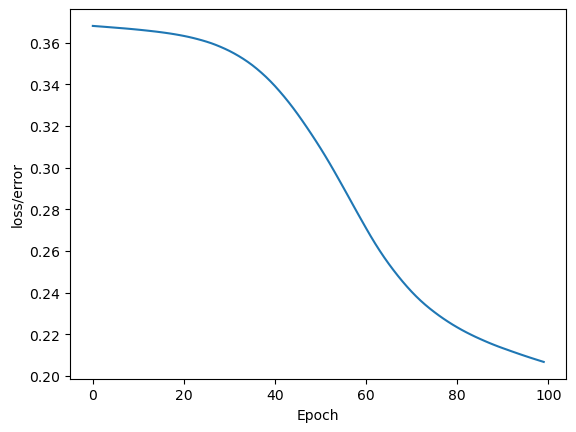

In [46]:
# Graph it out 
plt.plot(range(n_epochs), list_loss)
plt.ylabel('loss/error')
plt.xlabel('Epoch')

### Explain ANN with SHAP

In [47]:
#### Explain NN_model
NN_model.eval()
take_sample = X_train_tensor ### we can adjust size of take_sample
explainer = shap.DeepExplainer(NN_model, take_sample )

In [48]:
shap_values = explainer.shap_values(take_sample, check_additivity=False)


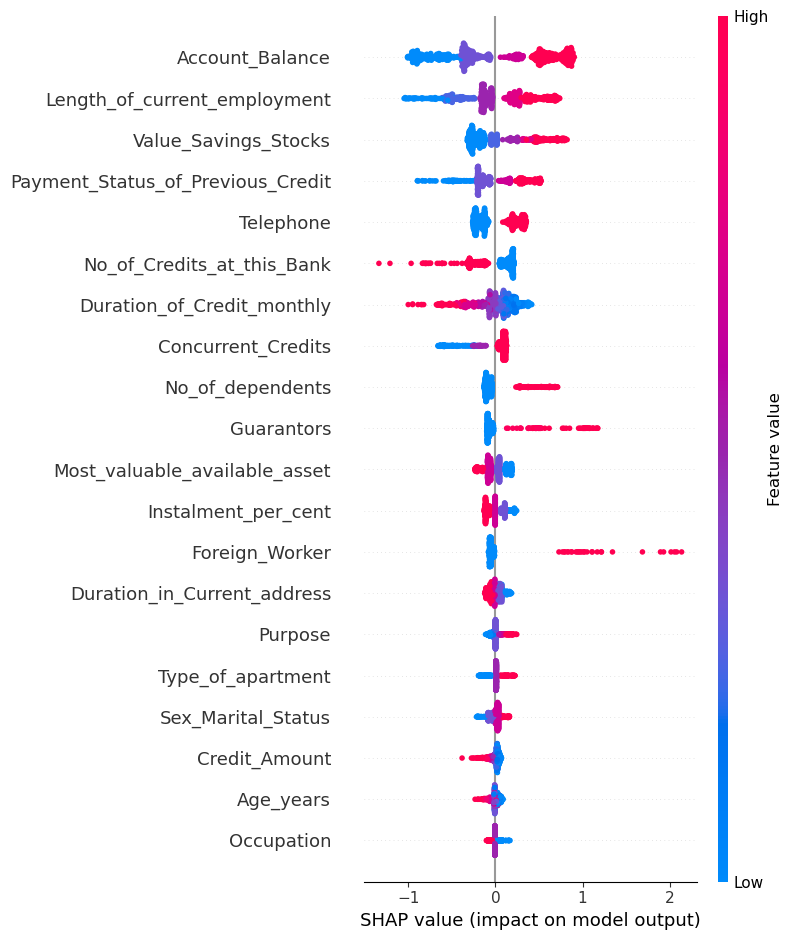

In [49]:
### reshape value and plot SHAP
reshaped_shap_values = shap_values.reshape(take_sample.shape)
shap.summary_plot(reshaped_shap_values,take_sample, feature_names=feature_names)

### Explain NNA with ALE

In [50]:
from alibi.explainers import ALE

In [51]:
def predict_fn(X):
    X_tensor = torch.tensor(X, dtype=torch.float32)
    with torch.no_grad():
        return NN_model(X_tensor).numpy()

# Initialize the ALE explainer
ale = ALE(predict_fn, feature_names= feature_names)

# Fit the ALE explainer to the training data
ale_exp = ale.explain(X_train)

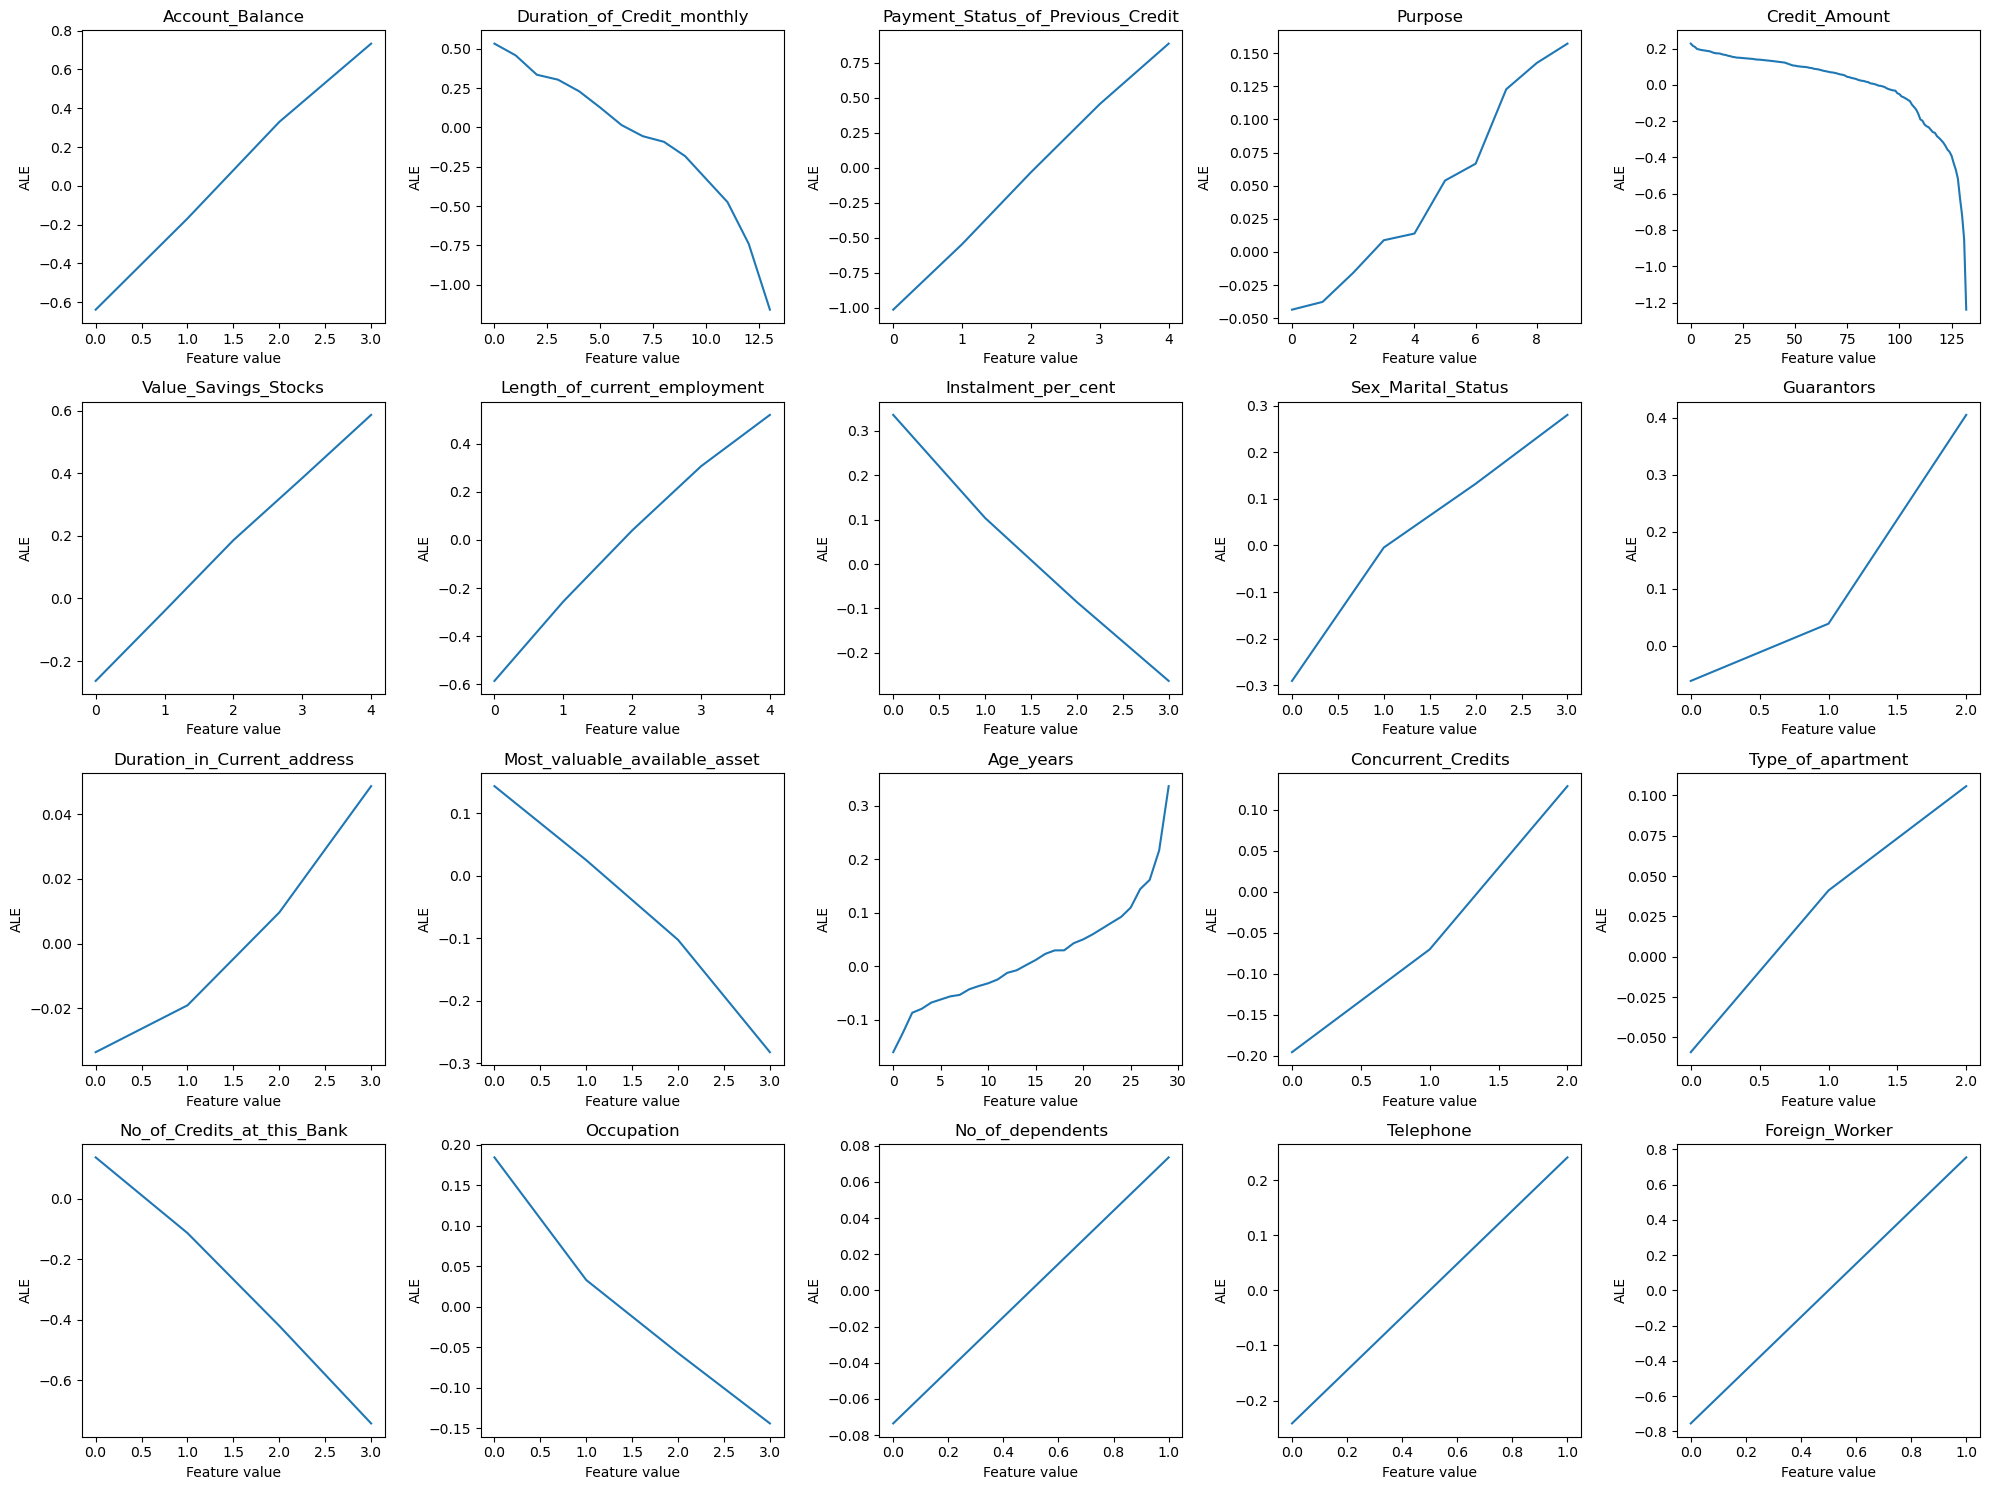

In [52]:
# Plot ALE
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(20, 15))  ### adjust SHAPE of ax, here should be nrows = 3 and ncols = 4 
                                                            ### because we have 12 features (1 features is for response)
for i, axi in enumerate(ax.flat):
    if i < len(feature_names):
        axi.plot(ale_exp.ale_values[i])
        axi.set_title(feature_names[i])
        axi.set_xlabel('Feature value')
        axi.set_ylabel('ALE')
plt.tight_layout()
plt.show()

### XGBoost

In [53]:
import xgboost as xgb
from xgboost import XGBClassifier

In [54]:
model_XGB = XGBClassifier()

model_XGB.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [55]:
train_pred = model_XGB.predict(X_train)

#### Metrics Measurement

In [56]:
# Accuray Score on train dataset
accuracy_train = accuracy_score(y_train, train_pred)
print('\naccuracy_score on train dataset : ', accuracy_train)
f1_train = f1_score(y_train, train_pred)
print('f1_score on train dataset : ', f1_train)

# predict the target on the test dataset
predict_test = model_XGB.predict(X_test)
print('\nTarget on test data',predict_test) 

# Accuracy Score on test dataset
accuracy_test = accuracy_score(y_test,predict_test)
print('\naccuracy_score on test dataset : ', accuracy_test)
f1_test = f1_score(y_test, predict_test)
print('f1_score on test dataset : ', f1_test)



accuracy_score on train dataset :  1.0
f1_score on train dataset :  1.0

Target on test data [0 1 1 1 1 1 1 0 0 1 0 1 1 0 0 1 1 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 1 0 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1
 1 1 1 1 0 0 1 1 0 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0 1
 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 0 0 0 0 1 0 1 1 0 1 0 1 0 1 1 1 0 0 0 1
 0 1 0 0 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1
 0 1 1 1 1 0 0 0 1 1 1 1 0 1 0]

accuracy_score on test dataset :  0.735
f1_score on test dataset :  0.8100358422939068


### Explain XGBoost with SHAP

In [57]:
explainer_XGB = shap.TreeExplainer(model_XGB, X_train)
shap_values_XGB = explainer_XGB(X_train)

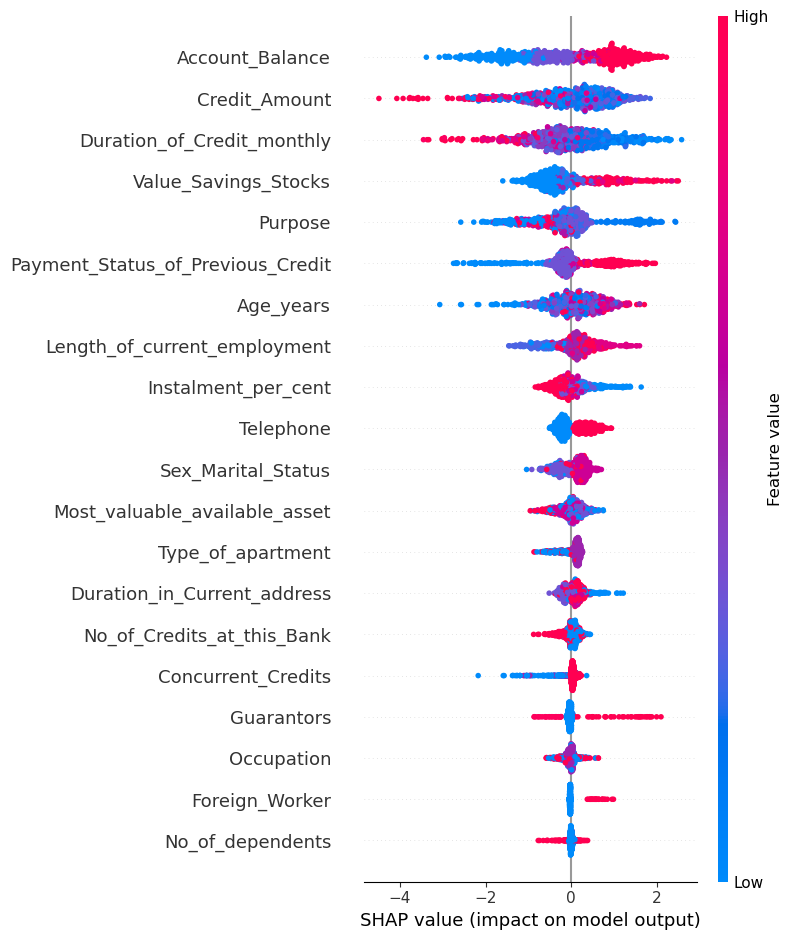

In [58]:
shap.summary_plot(shap_values_XGB, X_train, feature_names=feature_names)


### Explain XGBoost with ALE

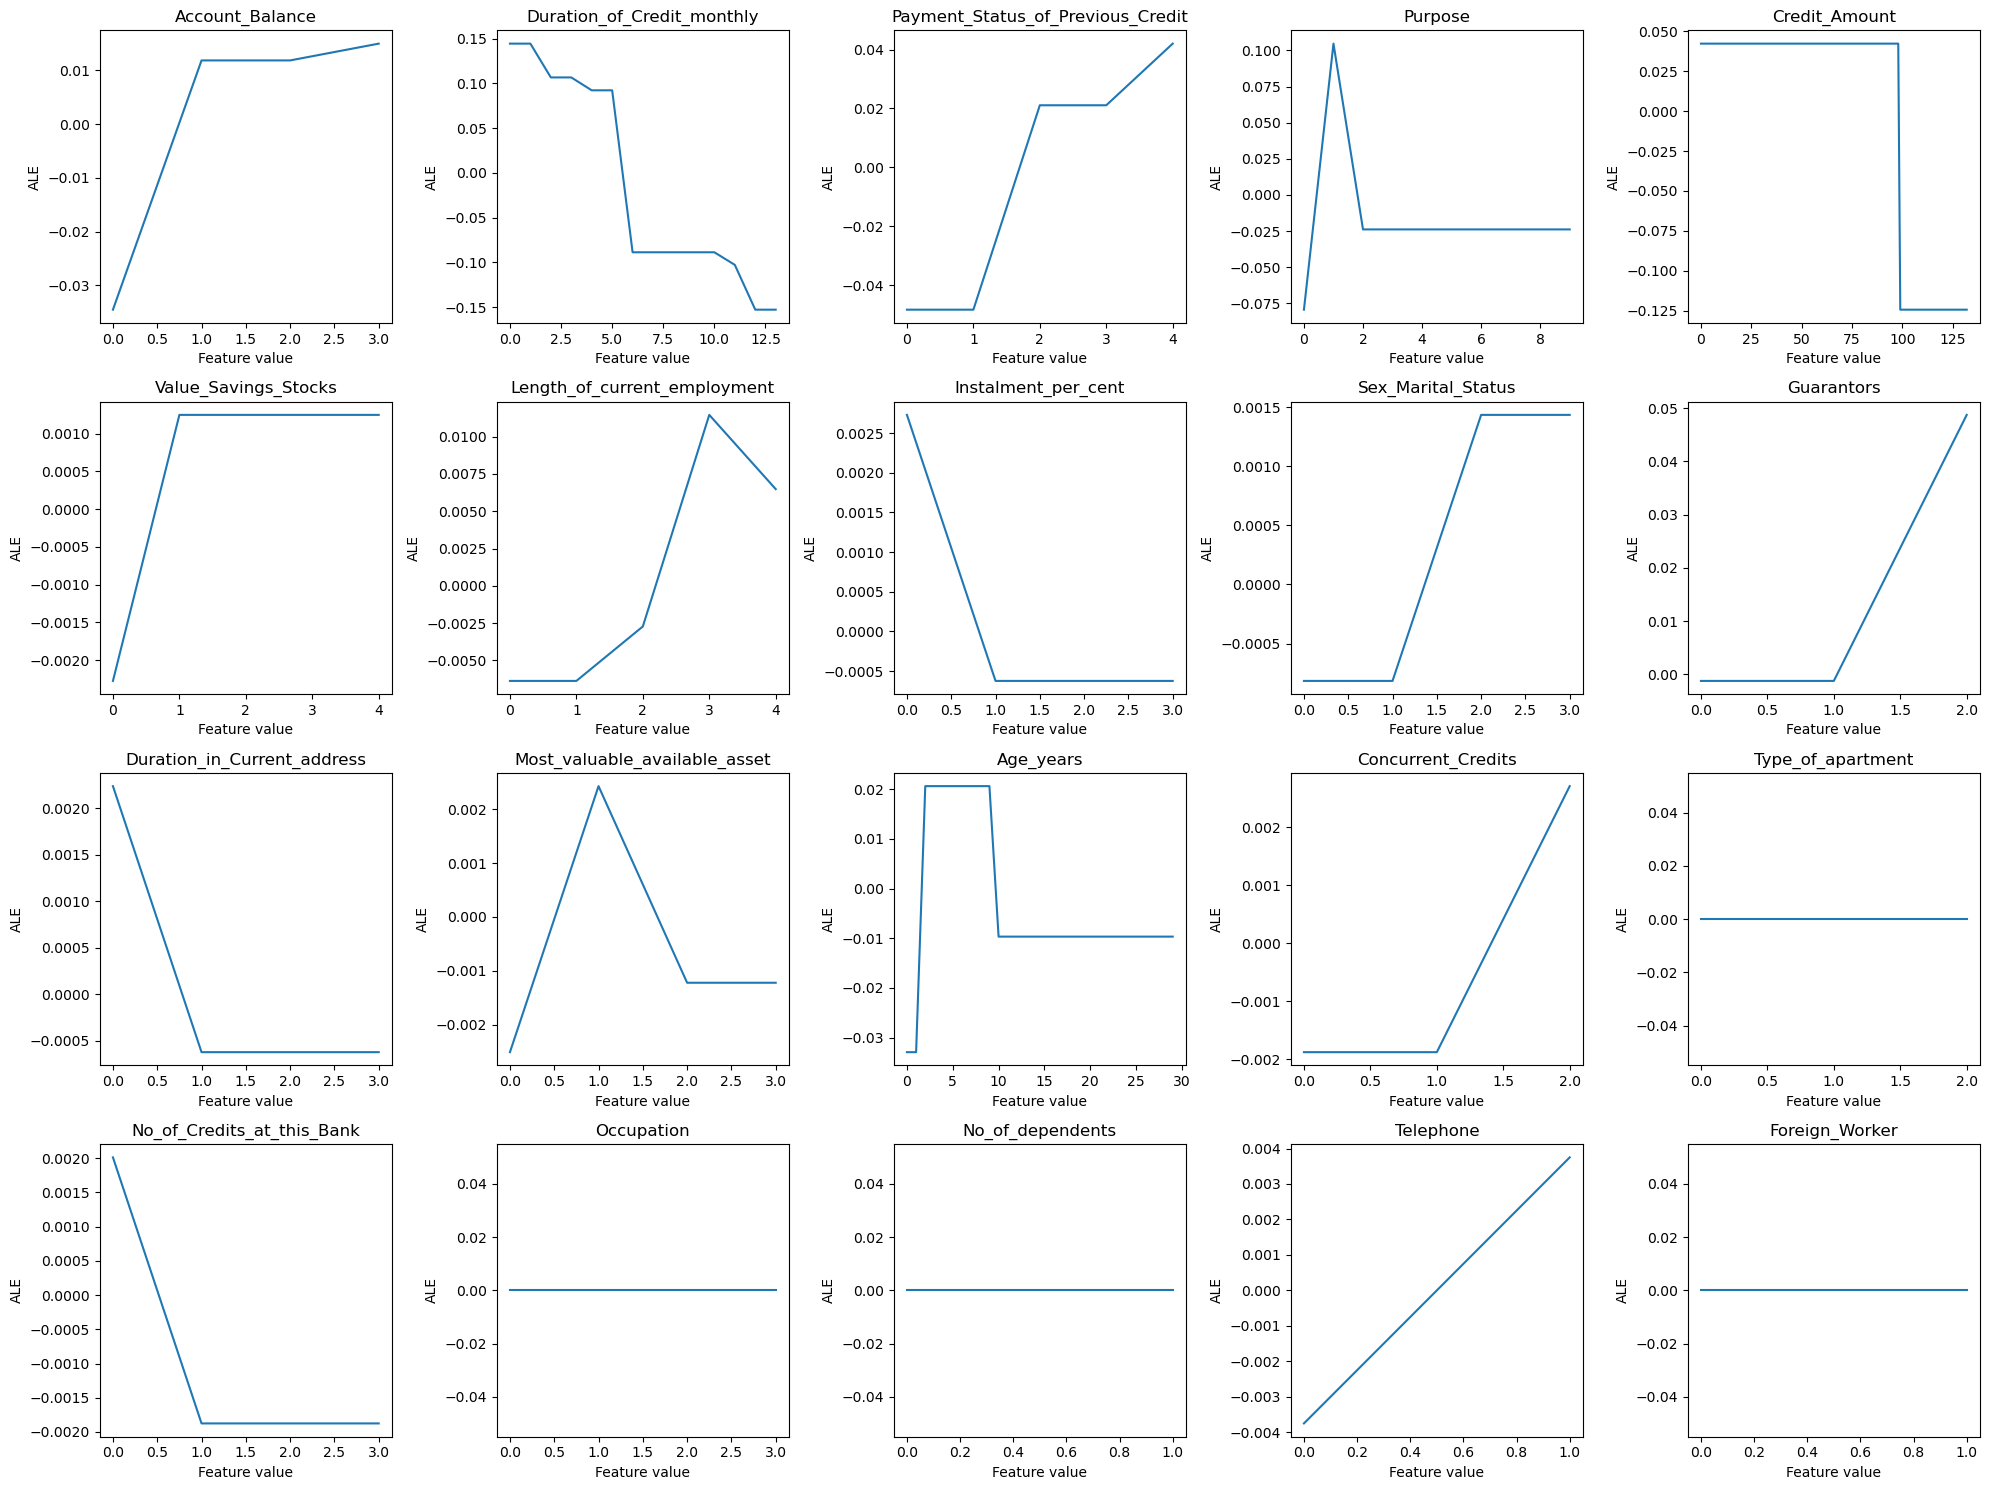

In [59]:
ale_XGB = ALE(model_XGB.predict, feature_names=feature_names)

# Fit ALE explainer
ale_exp_XGB = ale_XGB.explain(X_train)

# Plot ALE
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(20, 15))  
                                                            
for i, axi in enumerate(ax.flat):
    if i < len(feature_names):
        axi.plot(ale_exp_XGB.ale_values[i])
        axi.set_title(feature_names[i])
        axi.set_xlabel('Feature value')
        axi.set_ylabel('ALE')
plt.tight_layout()
plt.show()

### Analyzing Parameters Using Waterfall Plots


In [60]:
########### Idea: Make a for loop in range of X_train and X_test ->>>> where original_sample[8] = 2155...

sample index: 617 
Value of original_sample_2: [1.000e+00 1.500e+01 2.000e+00 0.000e+00 2.511e+03 1.000e+00 1.000e+00
 1.000e+00 2.000e+00 1.000e+00 4.000e+00 3.000e+00 2.300e+01 3.000e+00
 1.000e+00 1.000e+00 3.000e+00 1.000e+00 1.000e+00 1.000e+00]
2511.0


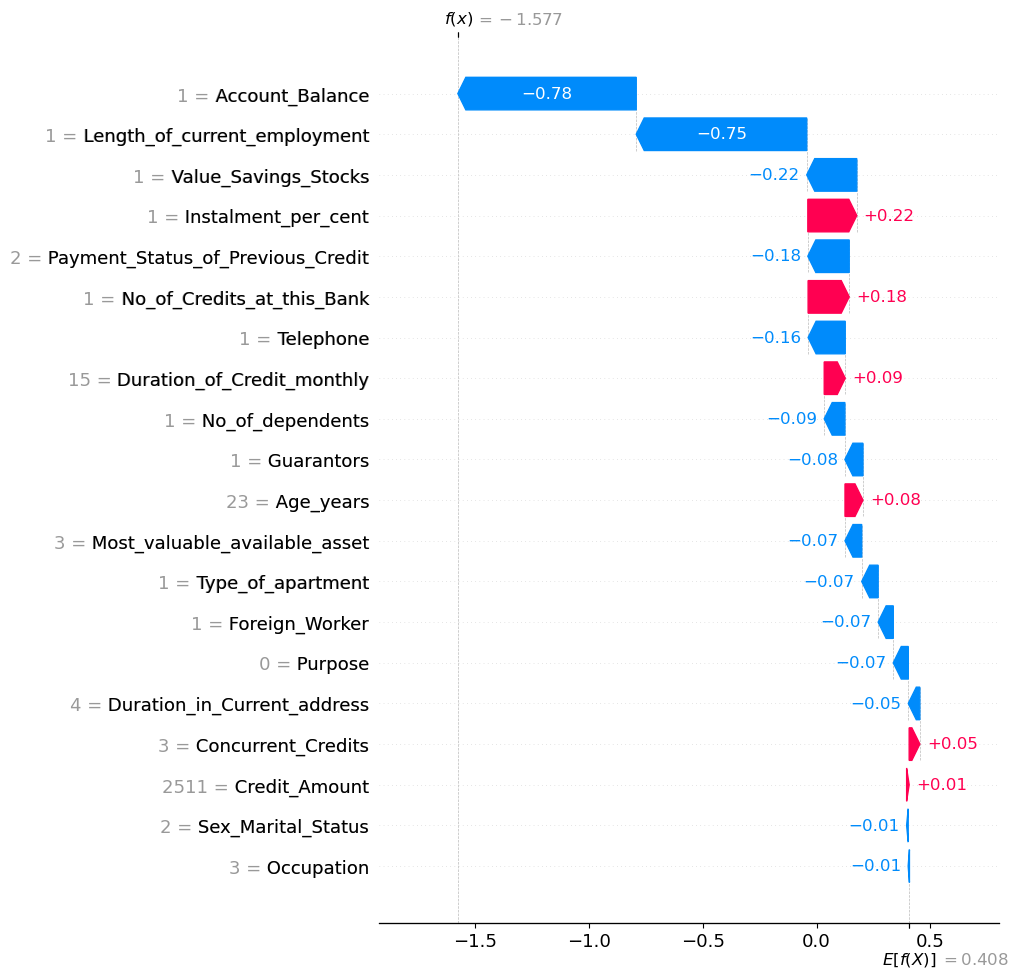

In [61]:

for i in range(0,800):
    sample_index = i
    # Get the scaled sample (as tensor or array)
    scaled_sample = X_train[sample_index]  # Scaled data from X_train
    scaled_sample_array = scaled_sample if isinstance(scaled_sample, np.ndarray) else scaled_sample.numpy()

    # Convert scaled data back to original data
    original_sample = scaler.inverse_transform(scaled_sample_array.reshape(1, -1)).flatten()
    if original_sample[4] == 2511:
        original_sample_2 = original_sample
        break
    

print(f'sample index: {sample_index} ')
print(f'Value of original_sample_2: {original_sample_2}')
print(original_sample_2[4])

# Compute SHAP values on the scaled sample
scaled_sample_tensor = torch.tensor(scaled_sample_array, dtype=torch.float32).unsqueeze(0)
shap_values_sample = explainer.shap_values(scaled_sample_tensor, check_additivity= False)

# Reshape SHAP values and extract the base value
reshaped_shap_values_sample = shap_values_sample[0].reshape(-1)
base_value = explainer.expected_value[0]

# Generate the SHAP waterfall plot using the original data
shap.waterfall_plot(
    shap.Explanation(
        values=reshaped_shap_values_sample,
        base_values=base_value,
        data=original_sample_2,  # Use original data for the plot
        feature_names=feature_names
    ),
    max_display=len(original_sample_2)
)

sample index: 656 
Value of original_sample_2: [1.000e+00 1.800e+01 2.000e+00 2.000e+00 2.473e+03 1.000e+00 1.000e+00
 4.000e+00 3.000e+00 1.000e+00 1.000e+00 3.000e+00 2.500e+01 3.000e+00
 2.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
2473.0


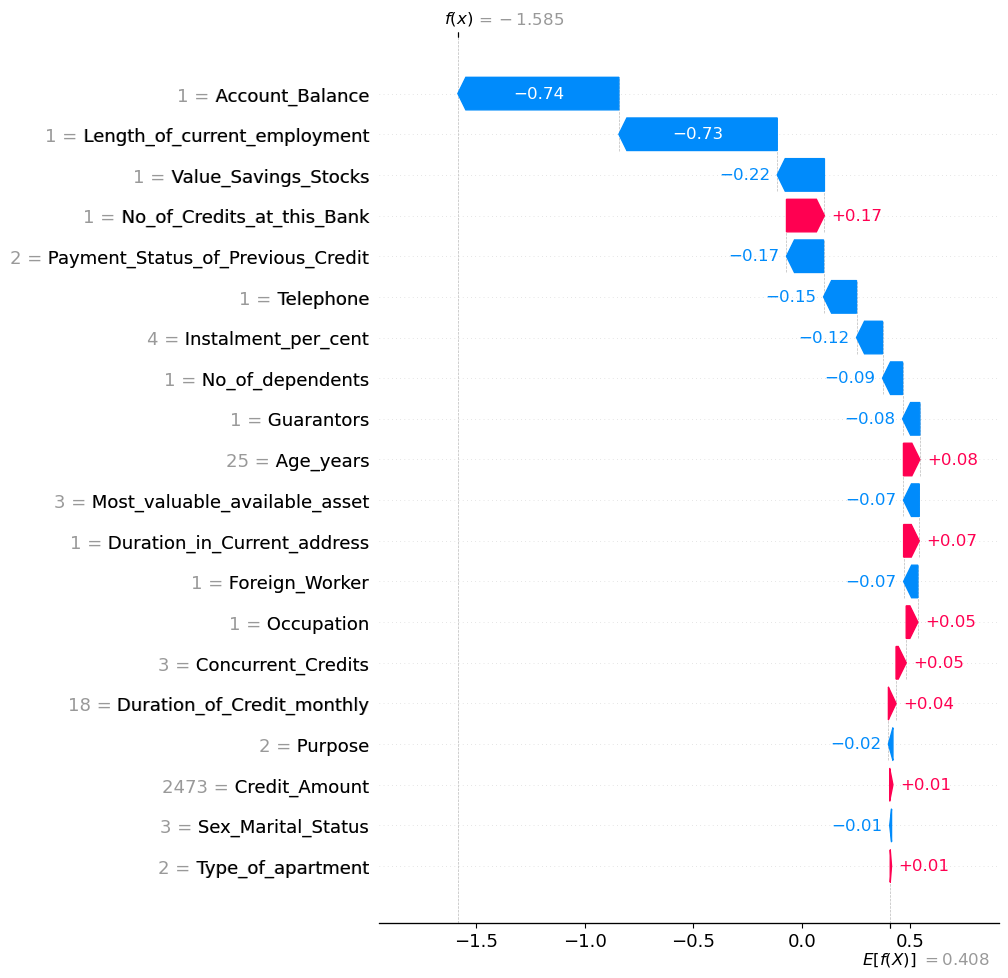

In [62]:
## For 2473
for i in range(0,800):
    sample_index = i
    # Get the scaled sample (as tensor or array)
    scaled_sample = X_train[sample_index]  # Scaled data from X_train
    scaled_sample_array = scaled_sample if isinstance(scaled_sample, np.ndarray) else scaled_sample.numpy()

    # Convert scaled data back to original data
    original_sample = scaler.inverse_transform(scaled_sample_array.reshape(1, -1)).flatten()
    if original_sample[4] == 2473:
        original_sample_2 = original_sample
        break
    

print(f'sample index: {sample_index} ')
print(f'Value of original_sample_2: {original_sample_2}')
print(original_sample_2[4])

# Compute SHAP values on the scaled sample
scaled_sample_tensor = torch.tensor(scaled_sample_array, dtype=torch.float32).unsqueeze(0)
shap_values_sample = explainer.shap_values(scaled_sample_tensor, check_additivity= False)

# Reshape SHAP values and extract the base value
reshaped_shap_values_sample = shap_values_sample[0].reshape(-1)
base_value = explainer.expected_value[0]

# Generate the SHAP waterfall plot using the original data
shap.waterfall_plot(
    shap.Explanation(
        values=reshaped_shap_values_sample,
        base_values=base_value,
        data=original_sample_2,  # Use original data for the plot
        feature_names=feature_names
    ),
    max_display=len(original_sample_2)
)